
# **Gestión de datos y datos digitales**
### **Autor: Ferran Carrascosa Mallafrè**

---
---

<!-- script html for image -->

<center>


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Star_Wars%2C_%C3%A9pisode_III_-_La_Revanche_des_Sith_logo.jpg/220px-Star_Wars%2C_%C3%A9pisode_III_-_La_Revanche_des_Sith_logo.jpg"  width="500" height="150"/>


<br>

Fuente de la imagen: [https://es.wikipedia.org](https://es.wikipedia.org/wiki/Star_Wars:_Episodio_III_-_La_venganza_de_los_Sith)

</center>

<br>

# **Índice**

---
---

> [Gestión de datos y datos digitales](#scrollTo=eJfiC-K0VViA&uniqifier=1)
<br>
>>
>> [Preparación del Entorno](#scrollTo=UkU8akIVtlbn&line=1&uniqifier=1) \\
>>   \\
>> [1.4. Social analytics: Hootsuite, Twitter analytics y Facebook insights](#scrollTo=U3oTMspTVVjE) \\
>>
>>> [1.4.1 Twitter analytics](#scrollTo=lsAECn4Bbkil&uniqifier=1) \\
>>>
>>> [1.4.2. Facebook insights](#scrollTo=921VyHG6bki3&uniqifier=1) \\
>>>
>>> [1.4.3. Hootsuite](#scrollTo=DHP_jCRpbki6&uniqifier=1)


# Preparación del entorno

Cargamos las librerías.

In [1]:
#!pip install tweepy --upgrade

import tweepy

print(tweepy.__version__)


4.6.0


In [2]:
import json
import pymongo
import tweepy
import urllib
import time

import pandas as pd
import numpy as np

# 1.4. Social analytics: Hootsuite, Twitter analytics y Facebook insights





## 1.4.1 Twitter analytics

Para obtener datos de Twitter des de Python se puede utilizar su propia API.

Por ejemplo: 

```
https://api.twitter.com/oauth/authenticate?oauth_token=XXXXXXXXXXXXXX

https://api.twitter.com/1.1/followers/ids.json?cursor=-1&screen_name=my_user_name&count=5000
```

Construir estas consultas, no siempre es fácil. Puede consultar la API completa en https://developer.twitter.com/en/docs/api-reference-index . Una forma de facilitar estas consultas es utilizar la librería **tweepy**. 


### Autenticación

Para conectarse a la  API  de Twitter (de tipo RESTful), es necesario autenticarse. Para obtener los datos necesarios se pueden seguir los siguientes pasos:

- Accede a la siguiente url: https://developer.twitter.com  e identifícate con tus credenciales de twitter (si no las tienes, entonces ha llegado el momento de abrirte una cuenta).
- Crea una nueva App. Esto creara las claves API (consumer_key, consumer_secret y bearer_token)


In [3]:
# copia tu bearer_token
bearer_token = 'XXXXXXXXXXXXXXXXXXX'


Ahora se autentica en Twitter.

In [4]:
client = tweepy.Client(bearer_token=bearer_token,wait_on_rate_limit=True)


### Consulta del perfil de un usuario

En la nueva API V2, en la llamda a `get_user()`, es necesario incluir las características del usuario en el parámetro user `user_fields` y de sus tweets   en `tweet_fields`.

Verificamos que la api devuelve resultados consultando el perfil de twitter: @PyLadiesBCN.


In [5]:
USER_NAME = "PyLadiesBCN"
user = client.get_user(username=USER_NAME, 
                       user_fields=["created_at","description","entities","id","location","name","pinned_tweet_id"
                       ,"profile_image_url","protected","public_metrics","url","username","verified","withheld"])


El nombre.

In [6]:
user.data.name

'PyLadies_BCN'

El id.

In [8]:
user.data.id

2355227816

La fecha de creación del perfil.

In [9]:
user.data.created_at

datetime.datetime(2014, 2, 21, 19, 15, 16, tzinfo=datetime.timezone.utc)

El número de perfiles que está siguiendo.

In [10]:
user.data.public_metrics["following_count"]

269

El número de seguidores de este perfil.

In [11]:
user.data.public_metrics["followers_count"]

1392

Todo el json del perfil del usuario.

In [12]:
user.data.data

{'created_at': '2014-02-21T19:15:16.000Z',
 'description': 'pyladies-bcn@googlegroups.com',
 'entities': {'url': {'urls': [{'display_url': 'meetup.com/PyLadies-BCN/',
     'end': 22,
     'expanded_url': 'http://www.meetup.com/PyLadies-BCN/',
     'start': 0,
     'url': 'http://t.co/30EZOFGXXX'}]}},
 'id': '2355227816',
 'location': 'Barcelona',
 'name': 'PyLadies_BCN',
 'profile_image_url': 'https://pbs.twimg.com/profile_images/1230435421299118081/xT8Na4ic_normal.jpg',
 'protected': False,
 'public_metrics': {'followers_count': 1392,
  'following_count': 269,
  'listed_count': 63,
  'tweet_count': 887},
 'url': 'http://t.co/30EZOFGXXX',
 'username': 'PyLadiesBCN',
 'verified': False}

Además, a través de urllib se puede recuperar más información de interés, como la imagen del perfil.

In [13]:
img_url = user.data.profile_image_url
print(img_url)

https://pbs.twimg.com/profile_images/1230435421299118081/xT8Na4ic_normal.jpg


Guardamos la imagen en un fichero y la printamos en el notebook.

Text(0.5, 1.0, 'PyLadies_BCN')

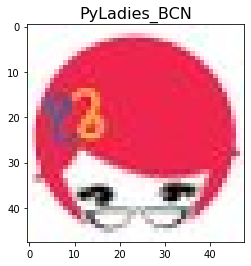

In [14]:
f = open('scraped_image','wb')
f.write(urllib.request.urlopen(img_url).read())
f.close()

%matplotlib inline
import matplotlib.pyplot as plt
im=plt.imread('scraped_image')
plt.imshow(im)
plt.title(user.data.name,size=16)

### Consulta de los seguidores de un usuario

Para obtener la lista de los ids de los seguidores, se puede utilizar la función `client.get_users_followers()`. La función retorna por defecto hasta 100 ids, se puede aumentar hasta un máximo de 1.000 ids con el parámetro `max_results`.

Para recuperar todos los seguidores de @pyladies, que tiene 1.280 seguidores, se necesita iterar más de una vez. Para ello, en tweepy puedes utilizar el objeto Paginator. Este recorre las distintas paginas de forma implícita sin problemas de límites. 

No obstante, en caso de realizar varias veces la consulta, tweepy te va a dar un aviso de espera. Es habitual llegar a tiempos de espera de 15 minutos. Además, existe un límite de 500.000 twitts al mes.  Puedes consultar más sobre las [tasas de límites](https://developer.twitter.com/en/docs/twitter-api/rate-limits) en el enlace. 


In [15]:
ids = []

# con limit=14 podemos descargar hasta 14*100 ids.
for page in tweepy.Paginator(client.get_users_followers, user.data.id, max_results=100, limit = 14):
  for response in page.data:
    ids.append(response.data["id"])

len(ids)


1392

> *Importante*: El parámetro `wait_on_rate_limit=True` de la conexión con `tweepy.Client()` va a aplicar tiempos de espera que te informará, cuando sea necesario con un aviso del tipo: `Sleeping for 223 seconds.

In [16]:
# ids de los followers
ids[0:10]

['1599071351322677257',
 '824938434275995648',
 '3218119641',
 '1465993716070424577',
 '779116237842321408',
 '14861462',
 '2320481186',
 '2814884142',
 '1597611211725602816',
 '1242728539461496833']

Antes de guardar los datos, en el caso de Colab se debe instalar MongoDB e iniciar el servicio:

In [17]:
!apt install mongodb >log
!service mongodb start


"apt" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"service" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Ahora Guardamos los datos de los ids en MongoDB.

Para esto, conectamos a MongoDB, creamos la base 'twitter' y Collection 'twitter_users'.


In [ ]:
document={}
document['user'] = user.data.id
document['followers'] = ids[:]

# Create the connection to MongoDB
try:
    conn=pymongo.MongoClient()
    print("Connection to Mongo Daemon successful!!!")
except pymongo.errors.ConnectionFailure:
    print("Could not connect to MongoDB")

db = conn['twitter']
collection = db['twitter_users']
# collection.drop()
collection.insert_one(document)

In [ ]:
collection.estimated_document_count()

In [20]:
doc = collection.find_one()

In [ ]:
doc['user']

In [ ]:
doc['followers'][0:10]

### Twitter Timeline

La API V2 da distintos métodos de acceso al timeline. 

Para obtener los últimos 5 tweets de un usuario con su id:


In [18]:
# Replace user ID
id = '2355227816'

tweets = client.get_users_tweets(id=id, tweet_fields=["public_metrics","context_annotations","created_at","geo","lang"],max_results =5)

# Otros campos de teet disponibles:
#"context_annotations","conversation_id","id","possibly_sensitive","entities","in_reply_to_user_id","referenced_tweets","reply_settings","source","withheld"

for tweet in tweets.data:
    print(tweet)

RT @PyBCN: Dear Pythonists, we are glad to announce the schedule of PyDay BCN 2022 🥳 Come and check it https://t.co/DKyJweUCKw
RT @pyladies: #NewProfilePic Today we feature PyLadies Barcelona, Spain PyLadiesBCN as our avatar. Check out their website: https://t.co/73…
PyDay BCN 2022 will be awesome! 🤩 Join us as speaker, sponsor or volunteer!! https://t.co/wQkWyfmz88
October @PyLadiesBCN Meetup is ready! First steps to open source within Hacktoberfest 2022 by @draentropia at @CanodromBCN Come and join us https://t.co/qWdKKwKXzw https://t.co/ME13kdu7tz
September @PyLadiesBCN meetup: Python for technial interviews 🤩 @lpmayos show us how to use Python Poetry, Click and Pytest!! Thanks @happy_scribe for hosting us! https://t.co/TCuEgVb3bV


Puedes ver [lista completa de campos por entidad](https://developer.twitter.com/en/docs/twitter-api/fields). También puedes ampliar algún campo de interés como [context_annotations](https://developer.twitter.com/en/docs/twitter-api/annotations/overview). 

Mediante `.search_recent_tweets()` se peuden descargar los tweets de los últimos 7 días sobre todo twitter a partir de una [consulta](https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md). En este caso vemos los tweets de los ultimos 7 días de @pythontrending que no sean re-tweets con la consulta: `"from:pythontrending -is:retweet"`.

In [19]:
# Replace with your own search query
query = 'from:pythontrending -is:retweet'

tweets = client.search_recent_tweets(query=query, tweet_fields=['context_annotations', 'created_at'], max_results=10)

for tweet in tweets.data:
    print(tweet.text)
    if len(tweet.context_annotations) > 0:
        print(tweet.context_annotations)

CyberSecurity - This is a repository where i collect my knowledge to different kind of topics related to cybersecurity. https://t.co/euT6n02vrK
[{'domain': {'id': '46', 'name': 'Business Taxonomy', 'description': 'Categories within Brand Verticals that narrow down the scope of Brands'}, 'entity': {'id': '1557697333571112960', 'name': 'Technology Business', 'description': 'Brands, companies, advertisers and every non-person handle with the profit intent related to softwares, apps, communication equipments, hardwares'}}, {'domain': {'id': '30', 'name': 'Entities [Entity Service]', 'description': 'Entity Service top level domain, every item that is in Entity Service should be in this domain'}, 'entity': {'id': '848920371311001600', 'name': 'Technology', 'description': 'Technology and computing'}}, {'domain': {'id': '30', 'name': 'Entities [Entity Service]', 'description': 'Entity Service top level domain, every item that is in Entity Service should be in this domain'}, 'entity': {'id': '8

O también, ver las estadísticas de cada tweet en formato dataframe, a través del normalizador de json a pandas: `pd.json_normalize()`.

In [20]:
df = pd.DataFrame()

for tweet in tweets.data:
  df = df.append(pd.json_normalize({'created_at':tweet.created_at, 'text':tweet.text, 'stats':tweet.public_metrics})) 

df.reset_index(drop=True, inplace=True)
df

,created_at,text,stats
0,2023-03-10 10:46:52+00:00,CyberSecurity - This is a repository where i c...,None
1,2023-03-10 10:46:46+00:00,aws-eks-best-practices - A best practices guid...,None
2,2023-03-10 10:46:40+00:00,faster-whisper - Faster Whisper transcription ...,None
3,2023-03-10 10:46:35+00:00,GPTQ-for-LLaMa - 4 bits quantization of LLaMa ...,None
4,2023-03-09 12:00:28+00:00,pybroker - Algorithmic Trading in Python with ...,None
5,2023-03-09 12:00:23+00:00,foundry-dev-tools - Foundry DevTools https://t...,None
6,2023-03-09 12:00:17+00:00,pyllama - LLaMA: Open and Efficient Foundation...,None
7,2023-03-09 12:00:11+00:00,"prismer - The implementation of ""Prismer: A Vi...",None
8,2023-03-08 14:13:23+00:00,mlproject https://t.co/EfmQsyDXkk,None
9,2023-03-08 14:13:17+00:00,chatllama - ChatLLaMA 📢 Open source implementa...,None


> Para ampliar conocimientos de API V2 y el paquete tweepy, muy recomendables estos 2 tutoriales:

- [Tutorial twitterdev](https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9).
- [Tutorial Jan Kirenz](https://www.kirenz.com/post/2021-12-10-twitter-api-v2-tweepy-and-pandas-in-python/twitter-api-v2-tweepy-and-pandas-in-python/).

### StreamingClient

La clase para generar un flujo de captura de datos en tiempo real de la API V2 se llama [StreamingClient()](https://docs.tweepy.org/en/stable/streamingclient.html).

Esta clase se acompaña con métodos `sample()` para [muestrear](https://developer.twitter.com/en/docs/twitter-api/tweets/volume-streams/introduction) y `filter()` para [filtrar](https://developer.twitter.com/en/docs/twitter-api/tweets/filtered-stream/introduction) los tweets en tiempo real. 

Para filtrar los tweets capturados, puedes ir a la [documentación de las consultas](https://developer.twitter.com/en/docs/twitter-api/tweets/filtered-stream/integrate/build-a-rule).

Para seleccionar los campos retornados por filter() consulta la documentación de [filter()](https://developer.twitter.com/en/docs/twitter-api/tweets/filtered-stream/api-reference/get-tweets-search-stream)

Esta clase, que se ejecuta manteniendo una conexión abierta, se acompaña de un conjunto de eventos para gestionar su funcionalidad. La más relevantes son  `on_tweet()`, para capturar el contenido de los tweets, `on_error` para gestionar los errores o `on_connect` que captura el momento de inicio.

In [21]:
# declaramos la clase listener que va a instanciar tweepy.StreamingClient 
class listener(tweepy.StreamingClient):
    # creamos un contador de twits capturados
    def on_connect(self):
        self.counter = 0
        self.limit = 5
    # evento que se ejeucta con cada tweet
    def on_tweet(self, tweet):
        print(tweet.text)
        print(tweet.created_at)
        print(self.counter)
        self.counter += 1
        if self.counter < self.limit:
            return True
        else:
            self.disconnect()
    def on_error(self, tweet):
        print(tweet)

# declaramos la instancia de tweepy.StreamingClient
listen = listener(bearer_token,wait_on_rate_limit=True)

# eliminamos las reglas previas
printer_rules = listen.get_rules()
if printer_rules.data is not None:
  listen.delete_rules([str(i.id) for i in listen.get_rules().data])

# declaramos la nueva regla
listen.add_rules(tweepy.StreamRule('Putin'))
# filtramos e indicamos los campos a recuperar.
listen.filter(tweet_fields=["created_at","text"])


@RayJPolitics1 So sad you have to watch Daddy Trump get beaten like a rented mule and then had to watch an alpha like Daddy Putin get his army destroyed in the same decade. The pain must be real.
2023-03-10 18:35:22+00:00
0
@AZgeopolitics https://t.co/0ApZ4hs7bZ
2023-03-10 18:35:23+00:00
1
@justindpeeler @Muchier_Alice_1 @plztellthetruth @williamlegate @MattWallace888 https://t.co/7YgOams8sO
2023-03-10 18:35:23+00:00
2
RT @abstractedaway: russian opposition is about non-accountability.  Imperialist Navalny is whitewashed into an excuse for business as usua…
2023-03-10 18:35:23+00:00
3


Stream connection closed by Twitter


@ReportingfromNY @RonFilipkowski Anything to get him in Prison.
2023-03-10 18:35:23+00:00
4


Se presenta un nuevo ejemplo donde se presenta el concepto de entidad, que permite capturar tweets asociados a lugares, por ejemplo: Barcelona.

In [22]:
# eliminamos las reglas previas
printer_rules = listen.get_rules()
if printer_rules.data is not None:
  listen.delete_rules([str(i.id) for i in listen.get_rules().data])

# declaramos la nueva regla
listen.add_rules(tweepy.StreamRule('entity:"Barcelona" -is:retweet'))
# filtramos e indicamos los campos a recuperar.
listen.filter(tweet_fields=["created_at","text"])


@EgoSumIlshe @Juanma44899534 @JeffryLeonCh @barakfever No todo pero si que hay bastante mas de lo que estás enterado. Messi no solo ha recibido ayudas en éste ultimo mundial, sino que ganó titulos y premios con Barcelona recibiendolas también. Así se infla a un jugador..... mejor silencio.
2023-03-10 18:37:54+00:00
0
@FCBarcelona_es “A traves de Rosell y Bartomeu el Barça alcanzó y mantuvo un acuerdo verbal estrictamente confidencial con Negreira a cambio de dinero para que realizase actuaciones tendentes a favorecer al Barcelona en la toma de decisiones de los árbitros”. https://t.co/wSp3dqhcFQ
2023-03-10 18:38:01+00:00
1
Cristiano Ronaldo won 5 Champions League and broke multiple Champions League records against the corruption from Barcelona 

He never had it easy 🐐 https://t.co/hHNi9zFWGN
2023-03-10 18:38:02+00:00
2
@futebol_info Quais as possíveis punições que o Barcelona poderia sofrer?
2023-03-10 18:38:06+00:00
3


Stream connection closed by Twitter


“A traves de Rosell y Bartomeu el Barça alcanzó y mantuvo un acuerdo verbal estrictamente confidencial con Negreira a cambio de dinero para que realizase actuaciones tendentes a favorecer al Barcelona en la toma de decisiones de los árbitros”. https://t.co/wSp3dqhcFQ https://t.co/ViPh7wamVC
2023-03-10 18:38:09+00:00
4


Puedes ver el detalle de la consulta `entity` en la documentación de [annotations](https://developer.twitter.com/en/docs/twitter-api/annotations/overview).



Vemos ahora como guardar estos tweets en MongoDB database.

Subimos el límite a 10 tweets con las menciones de "Putin".


In [ ]:
# declaramos la clase listener que va a instanciar tweepy.StreamingClient 
class listenerMDB(tweepy.StreamingClient):
    # creamos un contador de twits capturados
    def on_connect(self):
        try:
            self.conn=pymongo.MongoClient()
            print("Connection to Mongo Daemon successful!!!")
        except pymongo.errors.ConnectionFailure:
            print("Could not connect to MongoDB")
        self.db = self.conn['twitter_stream']
        self.collection = self.db['tweets']
        self.counter = 0
        self.limit = 10
    # evento que se ejeucta con cada tweet
    def on_tweet(self, tweet):
        document={'text':tweet.text, 'created':tweet.created_at, 'user_id':tweet.author_id}   
        print(document)     
        self.collection.insert_one(document) 
        self.counter += 1
        if self.counter < self.limit:
            return True
        else:
            self.disconnect()
    def on_error(self, tweet):
        print(tweet)

# declaramos la instancia de tweepy.StreamingClient
listen = listenerMDB(bearer_token,wait_on_rate_limit=True)

# eliminamos las reglas previas
printer_rules = listen.get_rules()
if printer_rules.data is not None:
  listen.delete_rules([str(i.id) for i in listen.get_rules().data])

# declaramos la nueva regla
listen.add_rules(tweepy.StreamRule('Putin'))
# filtramos e indicamos los campos a recuperar.
listen.filter(tweet_fields=["created_at","text","author_id"])
# ,"username"

In [ ]:
db = conn['twitter_stream']
collection = db['tweets']
collection.estimated_document_count()

In [ ]:
for doc in collection.find():
    print(doc)

StreamingClient permite implementar acciones en base a eventos de twitter en tiempo real.

## 1.4.2. Facebook insights

Facebook aporta un universo de APIs para poder obtener datos de su red social. La Facebook Insights API está orientada a realizar consultas de la plataforma de Marketing de Facebook. Esto incluye básicamente cualquier tipo de estadística que puedas encontrar en el Facebook Ad's Manager.

Este tema no va a entrar en detalle en la uso de Facebooks insights, pero aporta las indicaciones básicas para que puedas hacerlo.

### Generación del token de acceso

Ves a la [Facebook Marketing API](https://developers.facebook.com/docs/marketing-apis/). y sigue los pasos para [crear una nueva Ads App](https://developers.facebook.com/docs/development/create-an-app).

Asegúrate de añadir el producto "Marketing API". Una vez hecho, puedes acceder a tu pagina de gestión de ads page en  https://developers.facebook.com/apps/.

Ahora ve a Settings > Basic. Copia y pega tu App ID y App Secret algún sitio seguro.

Ve ahora a Products  > Marketing API > Tools. Selecciona ads_management and ads_read. Clica "Get Token". Tu token de acceso deberia aparecer en pantalla. Copia y pega este token en algún sitio seguro.

### Consulta la API

Las consultas utilizaran el paquete "facebook_business".



In [ ]:
from facebook_business.api import FacebookAdsApi
from facebook_business.adobjects.user import User

app_id = 'XXXXXXXXXXXXX'
app_secret = 'XXXXXXXXXXXXXXXXXXXXX'
access_token = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

FacebookAdsApi.init(app_id, app_secret, access_token, api_version='v13.0')

me = User(fbid='me')
my_accounts = list(me.get_ad_accounts())
print(my_accounts)

Una vez ya tienes el id entonces puedes introducirlo en la sigueiente consulta de los datos de la App.

In [ ]:
from facebook_business.api import FacebookAdsApi
from facebook_business.adobjects.adaccount import AdAccount

app_id = 'XXXXXXXXXXXXX'
app_secret = 'XXXXXXXXXXXXXXXXXXXXX'
access_token = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

FacebookAdsApi.init(app_id, app_secret, access_token, api_version='v13.0')

insights = AdAccount('act_XXXXXXXXXXXXXXX').get_insights()

print(insights)

En este ejemplo, la consulta aparece vacías. Para saber más sobre cómo funciona esta API, puedes consultar estos tutoriales:

- [Getting Started with Facebook Marketing API](https://www.damiengonot.com/blog/getting-started-with-facebook-marketing-api)
- [Guide to Facebook Insights API](https://www.damiengonot.com/blog/guide-facebook-insights-api)
- [Guide to Facebook Insights API (parte 2)](https://www.damiengonot.com/blog/guide-facebook-insights-api-2)

También pudes consultar los siguientes enlaces con información acerca del uso de las api's de facebook.

### Enlaces de interés de Facebook API

- [Leveraging Facebook Python API for Marketing Analytics](https://medium.com/analytics-and-data/leveraging-facebook-python-api-for-marketing-analytics-f4372f042112)
- [Publishing Facebook Ads With Python Step by Step](https://gokhang1327.medium.com/publishing-facebook-ads-with-python-step-by-step-5c2a98ee4d58)
- [facebook-python-business-sdk](https://github.com/facebook/facebook-python-business-sdk)
- [Marketing API SDK. V9.0](https://developers.facebook.com/docs/marketing-api/reference/sdks/python/v9.0)




## 1.4.3. Hootsuite

Hootsuite es una herramienta que ayuda a gestionar tus cuentas de redes sociales, perfecta para Community Managers y todas aquellas personas que quieren sacarle el máximo partido a las plataformas de social media.

Si quieres iniciarte en Hoostsuite, debes crear un usuario en https://hootsuite.com/ haciendo clic sobre "Crear una cuenta nueva". Posteriormente, puedes añadir una/o varias red/es social/es. Por ejemplo: Twitter, Facebook, LinkedIn...

Una de las principales ventajas de Hoostsuite es que te permite programar publicaciones con antelación. Incluso con la opción de "AutoSchedule" el mismo entorno de Hoostsuite la hora de publicación que va a conseguir mayor impacto.

También permite obtener estadísticas de las distintas redes sociales.

### Espacio de desarrolladores de Hootsuite

Puedes acceder al espacio de desarrolladores de aplicaciones basadas en Hootsuite en https://developer.hootsuite.com/.

La REST API, se puede consultar en al siguiente página: https://developer.hootsuite.com/docs/using-rest-apis.

### La librería hootsweet

También está disponible una librería de python llamada Hootsweet que facilita la interacción con el API. Puede consultar la documentación con ejemplos de acceso en https://pypi.org/project/hootsweet/.
